In [1]:
from PIL import Image
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", load_in_8bit=True, device_map={"": 0}, torch_dtype=torch.float16
)

bin F:\anaconda\envs\CRAWorksapce\Lib\site-packages\bitsandbytes\libbitsandbytes_cuda118.dll


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
import json
import os
from tqdm import tqdm
def MM_dataloader(target, seen, root_dic = 'hateful_memes'):
    res_dic = {}
    idx = 0
    if target == 'train':
        cur_path = os.path.join(root_dic, 'train.jsonl')
    elif target == 'val' and seen == True:
        cur_path = os.path.join(root_dic, 'dev_seen.jsonl')
    elif target == 'val' and seen == False:
        cur_path = os.path.join(root_dic, 'dev_unseen.jsonl')
    elif target == 'test' and seen == True:
        cur_path = os.path.join(root_dic, 'test_seen.jsonl')
    elif target == 'test' and seen == False:
        cur_path = os.path.join(root_dic, 'test_unseen.jsonl')
    with open(cur_path, 'r') as file:
        for line in tqdm(file):
            line = json.loads(line)
            img = line['img']
            img_path = os.path.join(root_dic, img)
            image = Image.open(img_path)
            keep = image.copy()
            label = line['label']
            text = line['text']
            res_dic[idx] = {'image':keep, 'text':text, 'label':label}
            image.close()
            idx += 1
    return res_dic

In [3]:
from peft import LoraConfig, get_peft_model
# Let's define the LoraConfig
config = LoraConfig(
    r=64,
    lora_alpha=256,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query", "key"]
)
{'num_epochs':4, 'lr_rate':5e-5, 'batch_size':8}
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 3,784,704 || all params: 3,748,464,640 || trainable%: 0.10096677876091689


In [ ]:
{'num_epochs':4, 'lr_rate':5e-5, 'batch_size':8}

In [4]:
test_seen = MM_dataloader('test', seen=False)

2000it [00:13, 146.05it/s]


In [5]:
train_seen = MM_dataloader('train', seen=False)

8500it [01:25, 99.35it/s] 


In [6]:
from torch.utils.data import Dataset, DataLoader
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        text = item["text"]
        label = item['label']
        encoding['label'] = label
        if item['label'] == 1:
            label = 'Yes, hate speech detected'
        else:
            label = 'No, no hate speech detected'
        prompt = f"Given the text from this image: {text}. Question: Does this image contain any information that could be considered hate speech? Answer: {label}"
        encoding["text"] = prompt
        
        return encoding


def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text" and key!='label':
            processed_batch[key] = torch.stack([example[key] for example in batch])
        elif key=='text':
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
        else:
            processed_batch["label"] = [example['label'] for example in batch]
    return processed_batch

In [7]:
train_dataset = ImageCaptioningDataset(train_seen, processor)
test_dataset = ImageCaptioningDataset(test_seen, processor)

In [8]:
config={'num_epochs':4, 'lr_rate':5e-5, 'batch_size':8}

In [9]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=config['batch_size'], collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=config['batch_size'], collate_fn=collate_fn)

In [10]:
import torch
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr_rate'])
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
def trainer(model, config, train_dataloader):
    model.train()
    loss_list = []
    for epoch in range(config['num_epochs']):
        t_loss = 0
        count = 0
        pbar = tqdm(enumerate(train_dataloader))
        for idx, batch in pbar:
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device, torch.float16)
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)
            logit = outputs.logits
            loss = outputs.loss  
            loss_list.append(loss.item())
            t_loss+=loss.item()
            pbar.set_description(f"[Training static], loss={loss.item()}")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            count += 1
        print('Avg_loss:', t_loss/count)
    return model, loss_list

In [12]:
model, loss_list = trainer(model, config, train_dataloader)

[Training static], loss=2.19140625: : 1063it [19:28,  1.10s/it]  


Avg_loss: 3.1925261274106305


[Training static], loss=1.1474609375: : 1063it [19:20,  1.09s/it]


Avg_loss: 2.0548096851481654


[Training static], loss=0.9892578125: : 1063it [19:15,  1.09s/it]


Avg_loss: 1.6440806348483066


[Training static], loss=1.314453125: : 1063it [18:38,  1.05s/it]  

Avg_loss: 1.4627978377822202


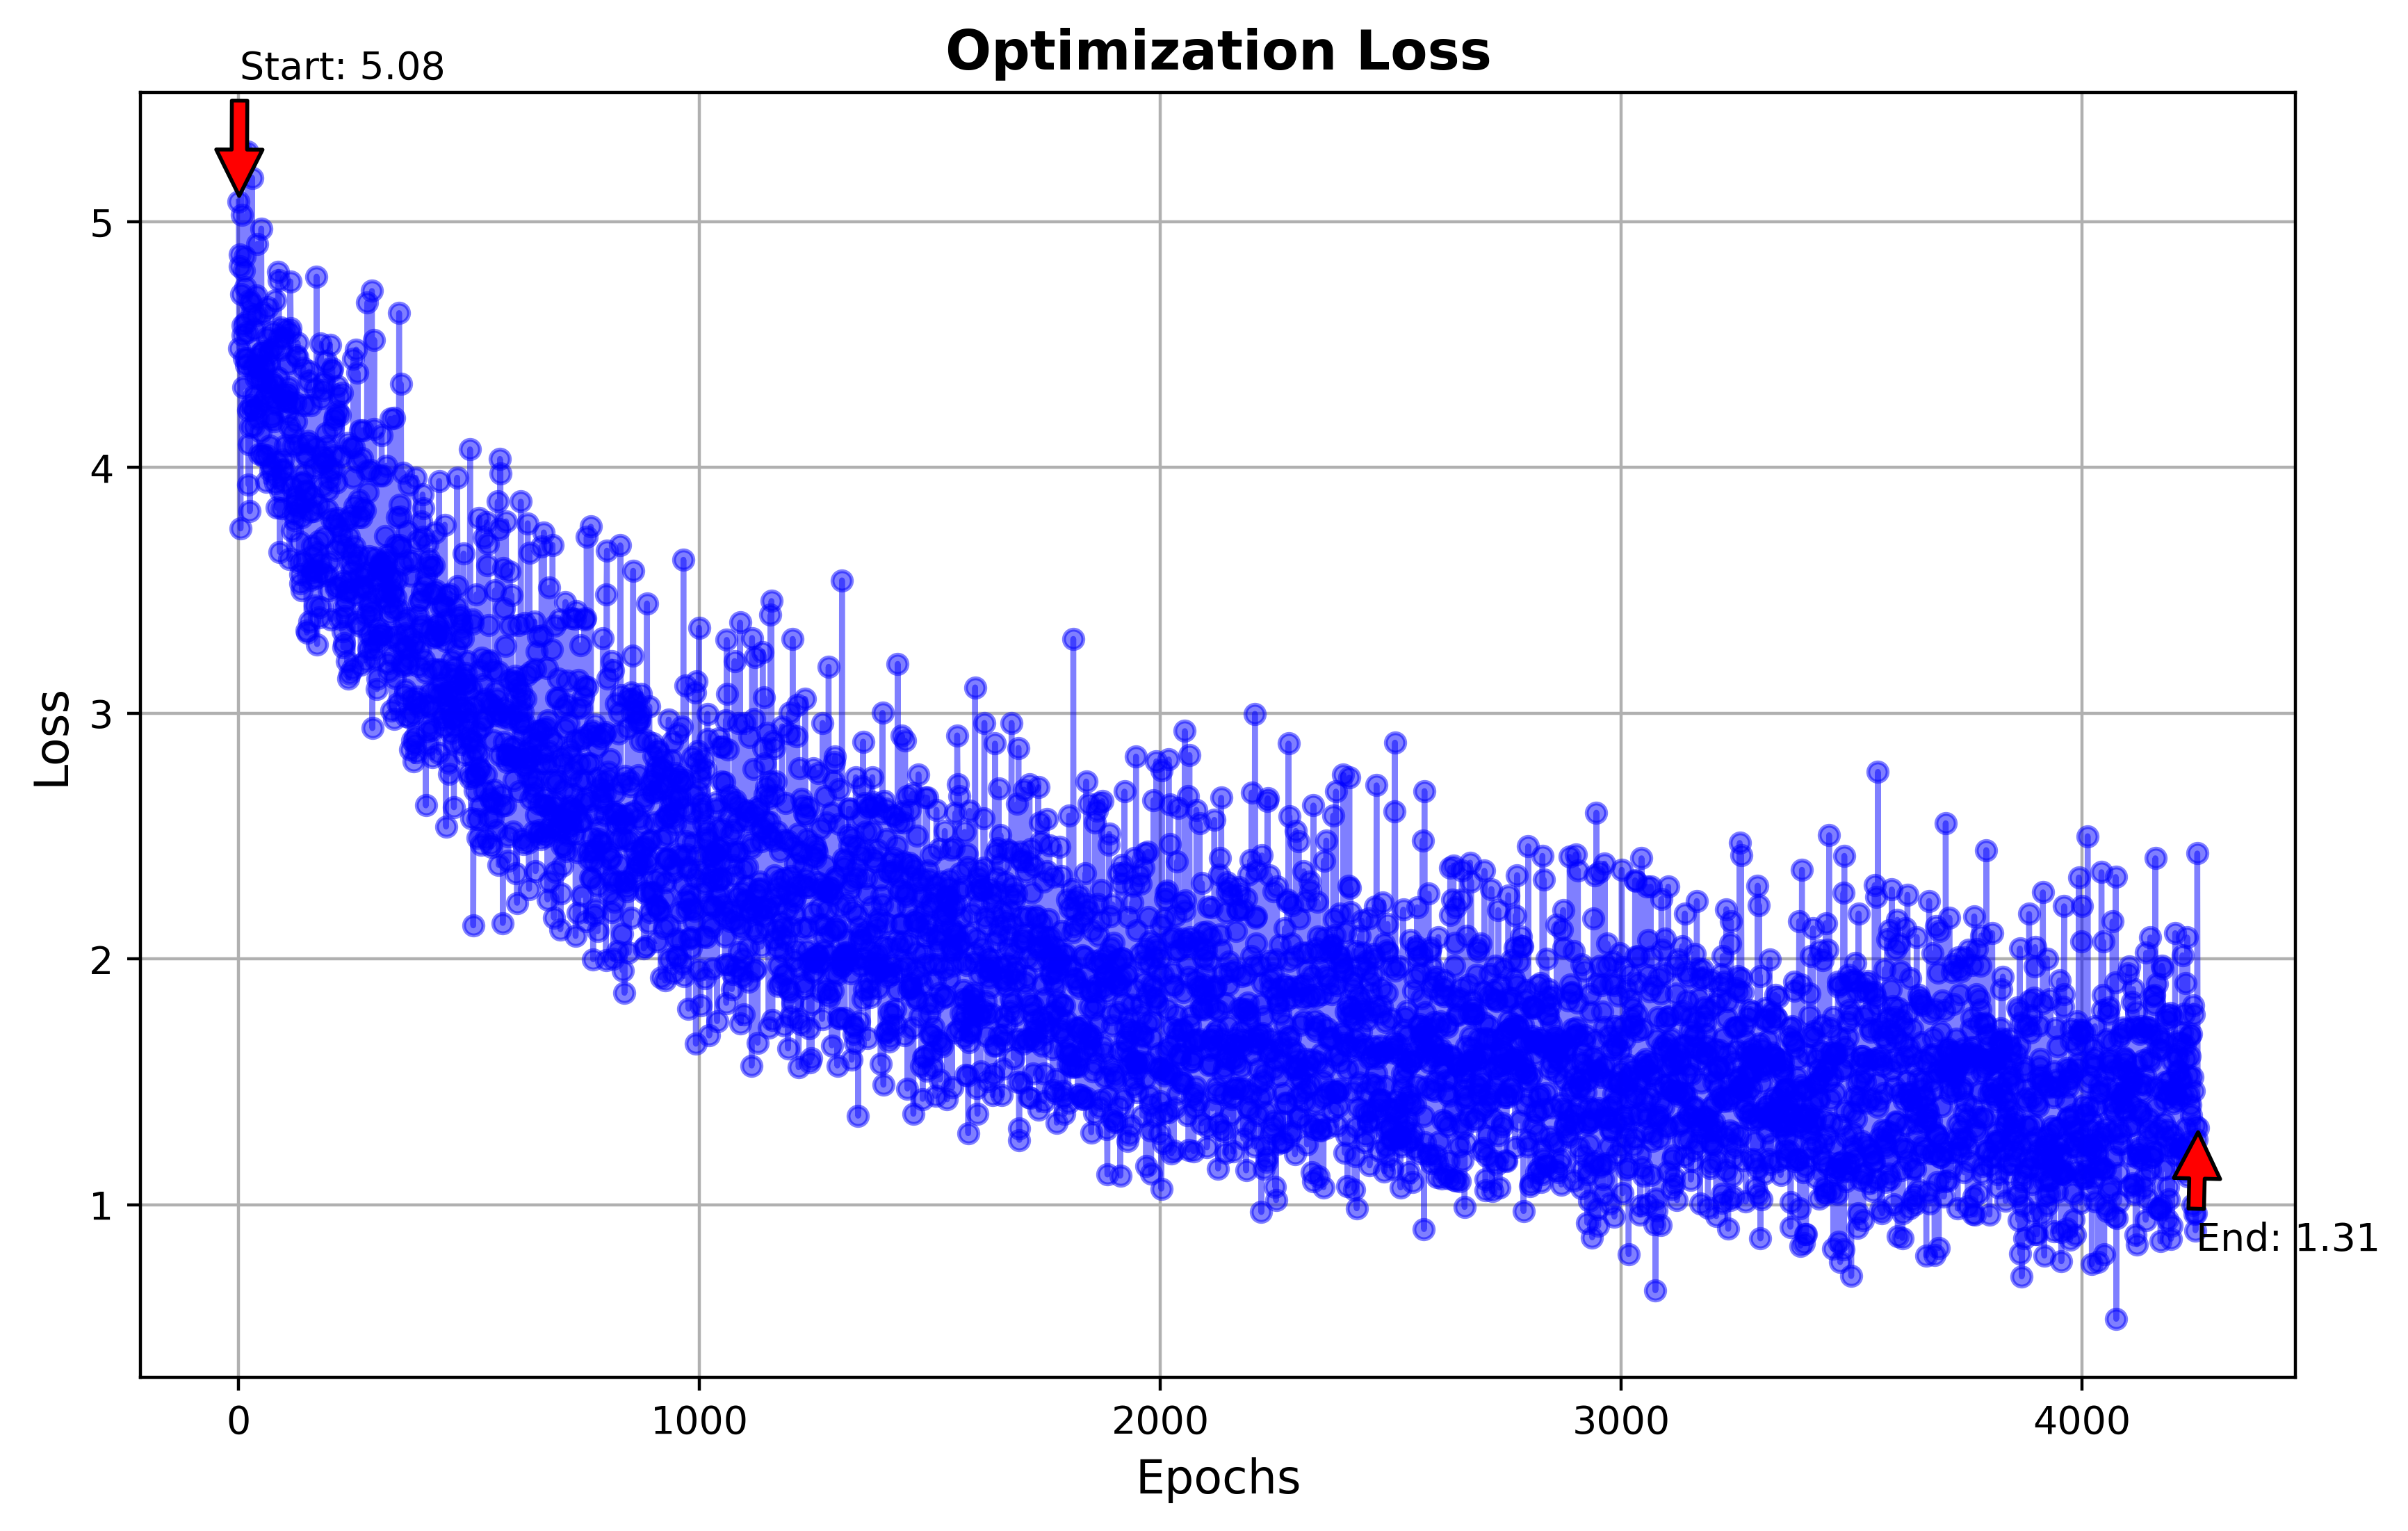

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6),dpi=400)
loss_values = loss_list
plt.plot(range(len(loss_list)), loss_values, color='blue', linestyle='-', marker='o', markersize=5, alpha=0.5)
plt.grid(True)
plt.title('Optimization Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)


plt.annotate(f'Start: {loss_values[0]:.2f}', xy=(1, loss_values[0]), xytext=(2, loss_values[0]+0.5),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate(f'End: {loss_values[-1]:.2f}', xy=(len(loss_values), loss_values[-1]),
             xytext=(len(loss_values)-5, loss_values[-1]-0.5), 
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()

In [14]:
from huggingface_hub import notebook_login
notebook_login()

In [16]:
model.push_to_hub("Jackline/Blip2-HateSpeech-Adapter-2.7b")

adapter_model.bin:   0%|          | 0.00/15.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Jackline/Blip2-HateSpeech-Adapter-2.7b/commit/a860b112c98b939485f8fd1392e755686bb5c118', commit_message='Upload model', commit_description='', oid='a860b112c98b939485f8fd1392e755686bb5c118', pr_url=None, pr_revision=None, pr_num=None)

In [133]:
def test_moudle_batch(model, test_loader):
    generated_label = []
    ground_truth = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device, torch.float16)
            labels = batch.pop("label")
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)
            logit = outputs.logits
            res = torch.argmax(logit, dim=-1).tolist()
            generated_text = processor.batch_decode(res, skip_special_tokens=True)
            generated_label.extend(generated_text)
            ground_truth.extend(labels)
    return generated_label, ground_truth

In [134]:
generated_label, ground_truth = test_moudle_batch(model, test_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [03:39<00:00,  1.14it/s]


In [152]:
predictions = []
for i in generated_label:
    last = i.split(':')[-1].strip()
    if 'No' in last:
        predictions.append(0)
    else:
        predictions.append(1)

In [ ]:
def test_moudle(model, test_loader):
    generated_label = []
    ground_truth = []
    for i in tqdm(test_loader.keys()):
        cur_info = test_loader[i]
        image = cur_info['image']
        text = cur_info['text']
        label = cur_info['label']
        prompt = f"Given the text from this image: {text}. Question: Does this image contain any information that could be considered hate speech? Answer:"
        inputs = processor(images=image, text=prompt, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        generated_label.append(generated_text)
        ground_truth.append(label)
    return generated_label, ground_truth

In [65]:
generated_label, ground_truth = test_moudle(model, test_seen)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [49:16<00:00,  1.48s/it]


In [71]:
filter_label = []
for i in generated_label:
    if 'Yes' in i:
        filter_label.append(1)
    else:
        filter_label.append(0)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, filter_label, digits=4, target_names=['Hate', 'Not Hate']))